In [1]:
import arch
import itertools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import seaborn as sns
import statsmodels.api as sm
import yfinance as yf
from datetime import date, timedelta
from statsmodels.tsa.stattools import adfuller

from algo.cointegration.augmented_dickey_fuller import adf_stationarity


sns.set_style("darkgrid")

# Model: ARMA(p,q) - GARCH(P,Q)

Methodology:
- Use ARIMA model to estimate the conditional mean.
- Use GARCH model to estimate the conditional variance present in the residuals of the ARIMA estimation.
- ARIMA assumes homoskedasticity (constant variance) --> therefore combine with GARCH.
- GARCH assumes constant mean (no skew or kurtosis) --> therefore combine with ARIMA.
- Not enough to use either separately.


ARIMA:
- Creates a linear combination of past returns and residuals to forecast future returns.
- Problems: change in variance over time, aka. "volatility clustering", aka. "conditional variance".


GARCH considers:
- Serial autocorrelation of errors.
- Volatility clustering.
- Heteroskedasticity.


ARIMA-GARCH allows for:
- Models with constant variance under ARMA(p,q).
- Models with Heteroskedasticity under GARCH(P,Q).


Define:
- p_t as the price series at time t.
- r_t as the LOG returns a time t.  I.e. r_t := ln(p_t) - ln(p_{t-1}).

Reference:
https://www.scirp.org/(S(i43dyn45teexjx455qlt3d2q))/journal/paperinformation.aspx?paperid=66652

In [2]:
# Data
num_data = 23*30*12
end_date = date.today()
start_date = end_date - timedelta(hours=num_data)
interval = "1h"

bz_df = yf.download("BZ=F", start=start_date.strftime("%Y-%m-%d"), end=end_date.strftime("%Y-%m-%d"), interval=interval)
cl_df = yf.download("CL=F", start=start_date.strftime("%Y-%m-%d"), end=end_date.strftime("%Y-%m-%d"), interval=interval)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [3]:
df = cl_df[["Adj Close"]].rename(columns={"Adj Close": "price"})
df.tail()

,price
2023-01-27 13:00:00-05:00,79.580002
2023-01-27 14:00:00-05:00,79.529999
2023-01-27 15:00:00-05:00,79.419998
2023-01-27 16:00:00-05:00,79.379997
2023-01-29 18:00:00-05:00,80.330002


# Transform Data - make stationary

In [4]:
# Test for Stationarity - ADF Test.
is_stationary = adf_stationarity(df["price"], trend="c")
print(f"price stationary = {is_stationary}")

# Perform differencing until stationary.
periods = 1
df[f"price_diff_{periods}"] = df["price"].diff(periods=periods)
df.dropna(inplace=True)

is_stationary = adf_stationarity(df["price_diff_1"], trend="c")
print(f"price diff 1 stationary = {is_stationary}")

price stationary = False
price diff 1 stationary = True


In [6]:
# Number of lags to trial.
lags = 25

conf_interval = {95: 0.05}
alpha = conf_interval[95]

acf, conf = sm.tsa.stattools.acf(x=df["price"], nlags=lags, alpha=alpha)

# Centre the confidence boundaries on the data.
conf_centred = conf - np.expand_dims(acf, axis=-1)

# Significant data: outside of the blue bands (above or below).
sig_data = np.abs(acf) >= conf_centred[:, 1]

# Largest lag of raw (non-differenced) price data.
max_lag = max(index for index, value in enumerate(sig_data) if value)
max_lag

25

/Users/joe/miniforge3/envs/ml/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


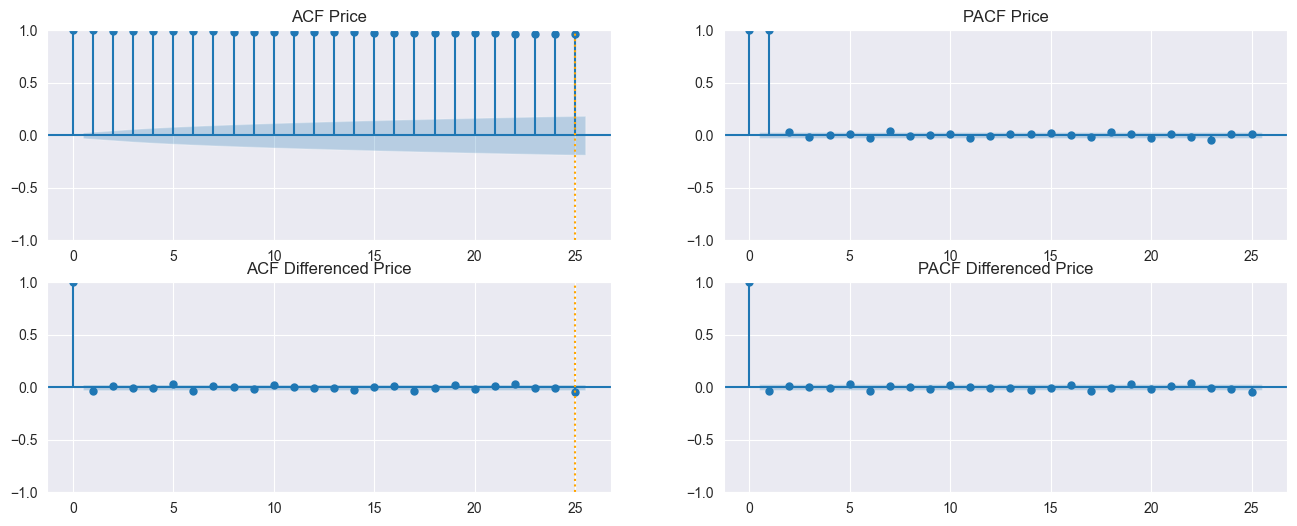

In [7]:
# NOTE: the blue bands are the error bands - anything within them is not statistically significant.
x = df["price"]

fig = plt.figure(figsize=(16, 6))

ax1 = fig.add_subplot(221)
fig = sm.graphics.tsa.plot_acf(x, lags=lags, ax=ax1)
plt.vlines(max_lag, ymin=-1.0, ymax=1.0, color="orange", linestyle="dotted")
plt.title("ACF Price")

ax2 = fig.add_subplot(222)
fig = sm.graphics.tsa.plot_pacf(x, lags=lags, ax=ax2)
plt.title("PACF Price")

# NOTE: the blue bands are the error bands - anything within them is not statistically significant.
x = df["price_diff_1"]

ax3 = fig.add_subplot(223)
fig = sm.graphics.tsa.plot_acf(x, lags=lags, ax=ax3)
plt.vlines(max_lag, ymin=-1.0, ymax=1.0, color="orange", linestyle="dotted")
plt.title("ACF Differenced Price")

ax4 = fig.add_subplot(224)
fig = sm.graphics.tsa.plot_pacf(x, lags=lags, ax=ax4)
plt.title("PACF Differenced Price")

plt.show()

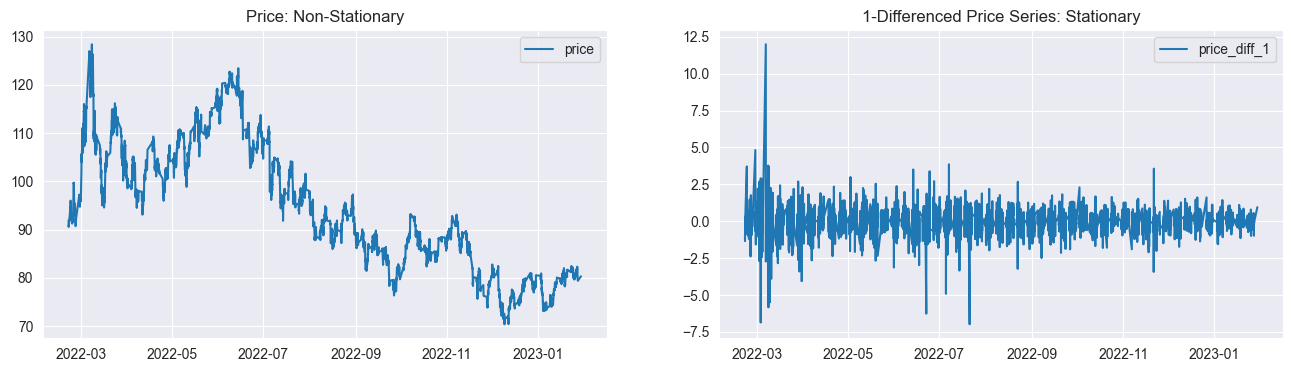

In [10]:
fig = plt.figure()
fig.set_size_inches(16, 4)

# Price.
plt.subplot(1, 2, 1)
plt.title("Price: Non-Stationary")
plt.plot(df["price"], label="price")
plt.legend()

# Differenced Price.
plt.subplot(1, 2, 2)
plt.title("1-Differenced Price Series: Stationary")
plt.plot(df["price_diff_1"], label="price_diff_1")
plt.legend()

plt.show()

1-Differenced Price Series:
- Mean stationary.
- Do not appear to be variance stationary.
- Observe: volatility clustering, jumps and spikes.

# Fit ARMA Model

In [8]:
# ARMA requires stationarity - once stationary, determine form of ARMA(p,q) model via the ACF and PACF functions for each series.
lags = 10

# ACF: correlation coefficient with each lag.
acf = sm.tsa.stattools.acf(x=df["price_diff_1"], nlags=lags)

# PACF: direct correlation of signal s_t with lag s_{t-k}, controlling for the effects of other variables, e.g. mutual correlations with other s_{t-i}.
pacf = sm.tsa.stattools.pacf(x=df["price_diff_1"], nlags=lags)

print(acf.shape, pacf.shape)

# Confidence interval is 95% by default.
indices = np.where(pacf > 0.05)
indices, pacf[indices]

(11,) (11,)


((array([0]),), array([1.]))

ARMA, ACF and PACF

AR <--> PACF.

MA <--> ACF.


AR Model: expresses the dependence of one variable on its own past value in an earlier time period.
- AR(p) model - signal S_t depends on last p time periods.
- Choose p from PACF using spikes.
- If ACF decays slowly, this also indicates AR process.


MA Model: calculates its forecast value as a weighted average of past errors.
- Captures trends and patterns in time series data.
- Assumes error, e_t ~ Normal(0, 1).
- Select q from ACF if there is a sharp cut-off after q periods (by which the past no longer has an effect).


AIC: can also select final ARMA model parameters by choosing the model with the smallest AIC.
1. AIC = n*ln(SSE/n) + 2k.
2. AIC = 2k - 2l.


Where: n = num obs; k = num indep vars (inc. intercept); l = log-likelihood.

ARMA specifies models for conditional mean and variance from the differenced series.
Can then use MLE to fit parameters for the specified model of the differenced series.

In [12]:
%%capture arima_capture
# Capture verbose logs from arima package. (Magic command must preceed this comment).


# Reduce num lags to search over cf. plots above
lags = 6
performance = {}

# AR(p) I(d), MA(q)
d = 0
for p, q in itertools.product(range(lags), range(lags)):
    # Fit ARMA model to the DIFFERENCED price series
    arima_model = sm.tsa.arima.ARIMA(endog=df["price_diff_1"].values, order=(p, d, q)).fit()
    performance[(p, q)] = arima_model.aic
    
# Find the (p, q) corresponding to the minimum AIC.
p_opt, q_opt = min(performance, key=performance.get)

# Fit the final model (not storing candidate model objects).
arima_model = sm.tsa.arima.ARIMA(endog=x, order=(p_opt, d, q_opt)).fit()

In [13]:
print(p_opt, q_opt)

2 3


# Test for Normality

In [14]:
# Jarque-Bera (JB) Test for Normality.
jb_value, p_value = scipy.stats.jarque_bera(arima_model.resid)
jb_value, p_value

(147835.26007399918, 0.0)

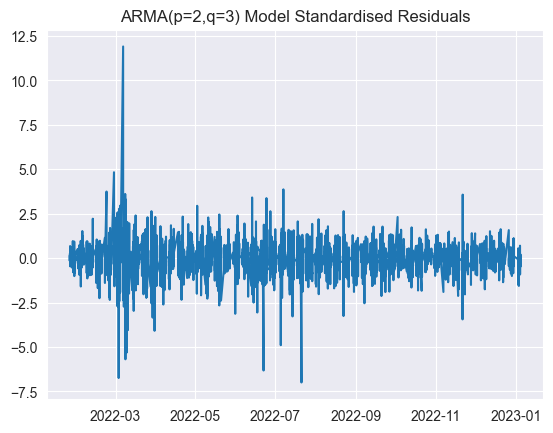

In [15]:
# After fitting model: standardise the inferred residuals and check for normality.
plt.plot(arima_model.resid)
plt.title(f"ARMA(p={p_opt},q={q_opt}) Model Standardised Residuals")
plt.show()

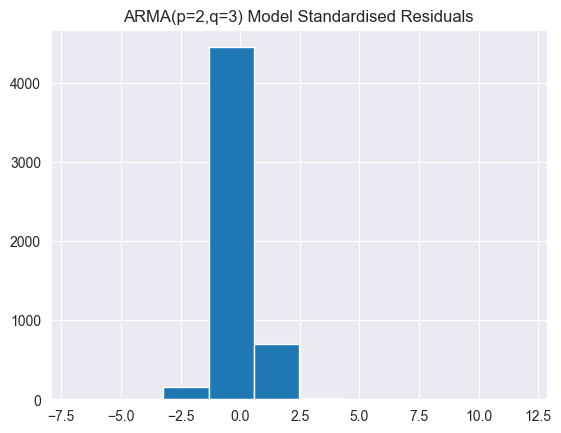

In [16]:
plt.hist(arima_model.resid)
plt.title(f"ARMA(p={p_opt},q={q_opt}) Model Standardised Residuals")
plt.show()

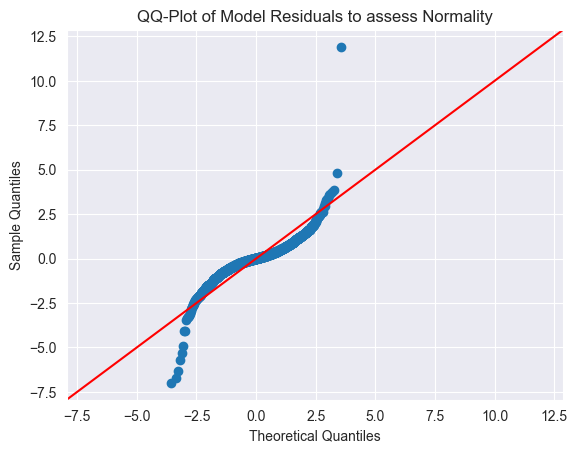

In [17]:
sm.qqplot(arima_model.resid, line="45")
plt.title("QQ-Plot of Model Residuals to assess Normality")
plt.show()

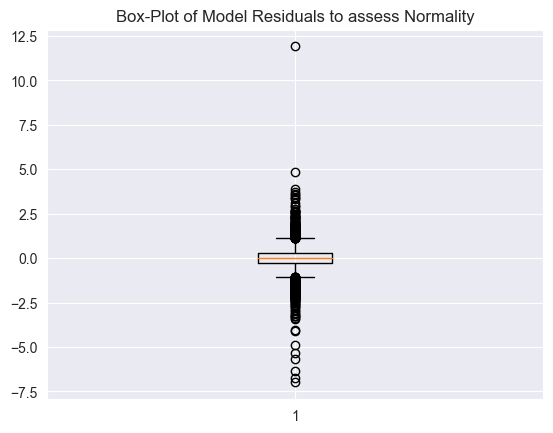

In [18]:
plt.boxplot(arima_model.resid)
plt.title("Box-Plot of Model Residuals to assess Normality")
plt.show()

NOTE:
1. JB Test for normality fails to reject the null-hypothesis that the data is non-normal.
2. Time series plot of residuals: clustering implies non-normality and non-constant variance.
3. Histogram plot of residuals: skew implies non-normality.
4. Q-Q Plot: implies non-normality due to extreme values.
5. Box Plot: implies non-normality due to extreme values.

# Serial Autocorrelation in Errors (Residuals) - ARCH Effects

Ljung-Box Test - use after fitting ARMA(p,q) model.
- Null hypothesis := any of a group of autocorrelations of a time series are different from 0.
- If there are small autocorrelations of residuals, conclude that the model does not exhibit significant lack of fit.

In [19]:
# High p-value (-> 1) indicates residuals are not autocorrelated.
lb_resid_df = sm.stats.acorr_ljungbox(x=arima_model.resid, lags=[p_opt, q_opt])
lb_resid_df

,lb_stat,lb_pvalue
2,0.373525,0.829641
3,0.415565,0.937009


In [20]:
# Small p-value for squared-residuals indicates ARCH effects in residuals.
lb_resid_sq_df = sm.stats.acorr_ljungbox(x=np.square(arima_model.resid), lags=[p_opt, q_opt])
lb_resid_sq_df

,lb_stat,lb_pvalue
2,32.759721,7.696918e-08
3,57.196129,2.333700e-12


/Users/joe/miniforge3/envs/ml/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


Text(0.5, 1.0, 'PACF for squared ARMA residuals')

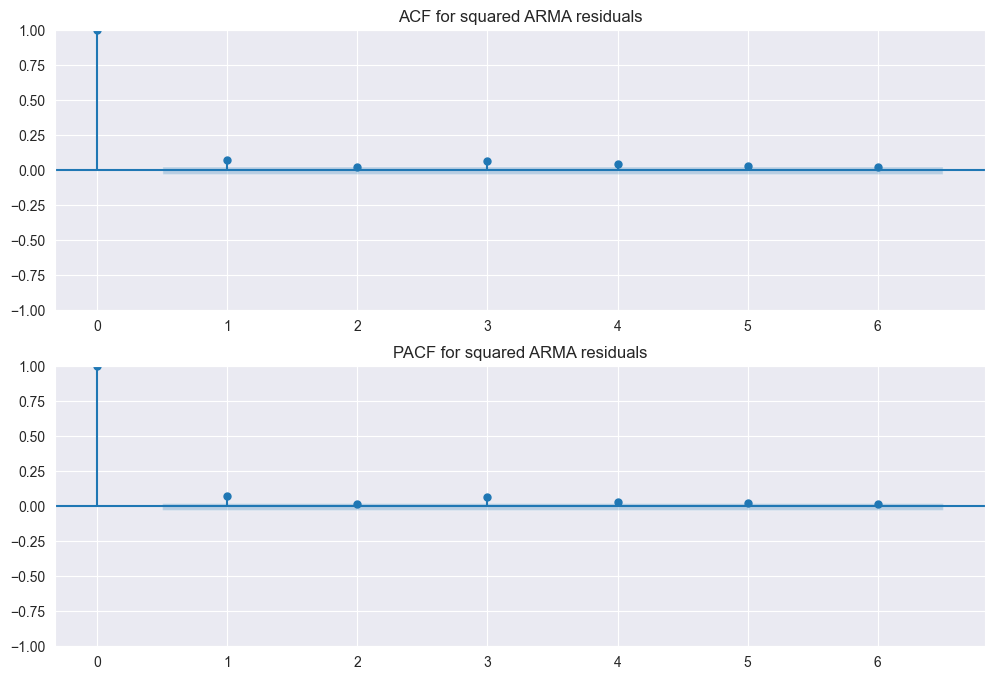

In [21]:
# Use PACF to assess order of ARCH model.
x = np.square(arima_model.resid)

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(x, lags=lags, ax=ax1)
plt.title("ACF for squared ARMA residuals")
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(x, lags=lags, ax=ax2)
plt.title("PACF for squared ARMA residuals")

Note: PACF(squared_resid):
- Lag 1: ARCH(1) --> GARCH(1,1).
- Lags 1 & 3.

# Volatility Clustering

Volatility clustering manifests as autocorrelation in squared (and absolute) returns, or in the residuals of the estimated conditional mean function.

/Users/joe/miniforge3/envs/ml/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


Text(0.5, 1.0, 'PACF for squared differenced prices')

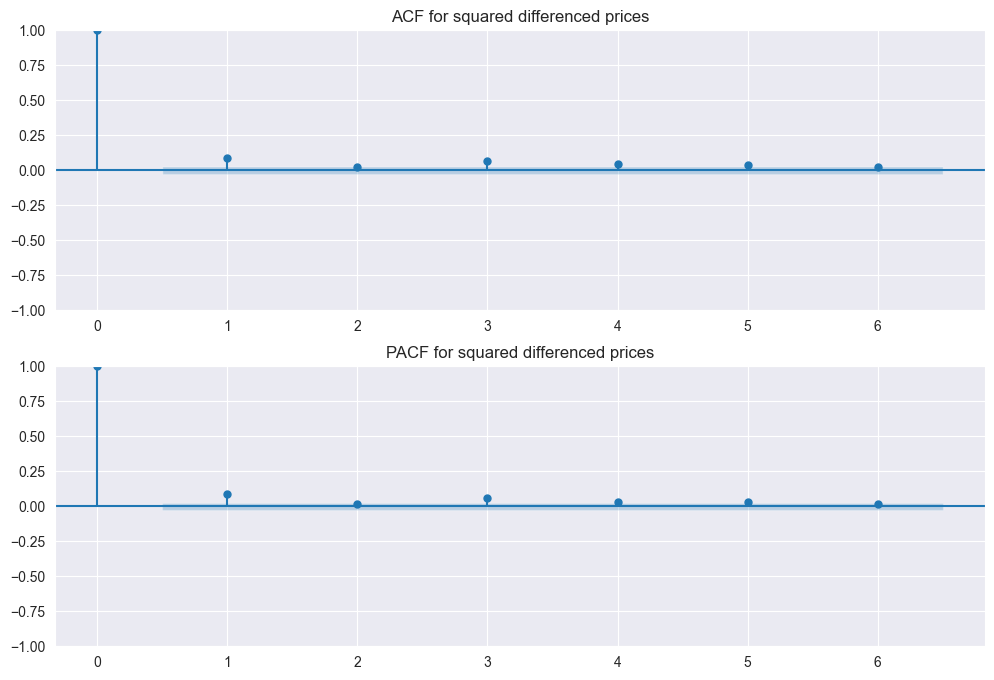

In [22]:
df["price_diff_1_sq"] = np.square(df["price_diff_1"])
x = df["price_diff_1_sq"]

# Use PACF to assess serial autocorrelation in squared differenced series..
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(x, lags=lags, ax=ax1)
plt.title("ACF for squared differenced prices")
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(x, lags=lags, ax=ax2)
plt.title("PACF for squared differenced prices")

# ARMA-GARCH Combined Predictions

- PACF(1) shows a dependency between lags of 1.
- Therefore: have serial autocorrelation in squared returns, i.e. conditional heteroskedasticity (conditional on lag=1).
- Can model serial autocorrelation in squared returns using GARCH.
- GARCH models can be expressed as an ARMA model of squared residuals.
- GARCH models with normal errors can replicate some of the fat tailed behaviour observed, though non-normal error distributions are need to capture all fat tail behaviour.

In [23]:
%%capture arch_capture
# Capture verbose logs from arch package. (Magic command must preceed this comment).


# Reduce num lags to search over cf. plots above.
lags = 6
performance = {}

# GARCH(P, Q) - note cannot have P=0 && o=0.
o = 0
for P, Q in itertools.product(range(lags)[1:], range(lags)):
    # Fit GARCH(P,Q) model to the differenced price series for (P,Q) candidates.
    garch_model = arch.arch_model(df["price_diff_1"].values, vol="garch", p=P, o=0, q=Q).fit()
    performance[(P, Q)] = garch_model.aic
    
# Find the (p, q) corresponding to the minimum AIC.
P_opt, Q_opt = min(performance, key=performance.get)

In [24]:
print(P_opt, Q_opt)

3 5


In [25]:
%%capture arch_capture
# Capture verbose logs from arch package. (Magic command must preceed this comment).


# Methodology 1: use ARIMA to compute the conditional mean at time t. Remember this is on the differenced series.
predicted_mean_t = arima_model.forecast(steps=1)

# Methodology 2: use GARCH to compute the conditional variance of the residuals of the ARIMA model.
garch_model = arch.arch_model(arima_model.resid, vol="garch", p=P_opt, o=0, q=Q_opt).fit()

# Methodology 3: 1-step OOS forecast.
garch_forecast = garch_model.forecast(horizon=1, reindex=False)

# GARCH predicted error at time t: `epsilon_t`.
predicted_error_t = garch_forecast.mean["h.1"].iloc[-1]

# Methodology 4: combine ARIMA + GARCH model outputs, using: y_hat_t = mu_t + epsilon_t
prediction = predicted_mean_t + predicted_error_t

In [26]:
print(f"ARIMA predicted mean = {predicted_mean_t}")
print(f"GARCH predicted error = {predicted_error_t}")
print(f"ARIMA-GARCH prediction = {prediction}")

ARIMA predicted mean = 5340    0.018174
dtype: float64
GARCH predicted error = 0.004653177182660772
ARIMA-GARCH prediction = 5340    0.022827
dtype: float64


In [27]:
# Inferred variances are conditioned on standard normal errror. Run many predictions and take an average.
num_trials = 1000
predicted_error_t_mean = np.mean([np.random.normal(loc=0.0, scale=1.0) * predicted_error_t for _ in range(num_trials)])

# ARIMA Model predicts the conditional mean for the DIFFERENCED series.
# "Undo" this by adding the prediction of the next difference to the current price.
price_tp1 = df["price"].iloc[-1] + predicted_mean_t + predicted_error_t_mean


print(f"ARIMA-GARCH next price prediction = {price_tp1}")

ARIMA-GARCH next price prediction = 5340    73.408025
dtype: float64


# Assessment of persistence of shocks on prices

In [28]:
# Assess impact of persistence: how long shocks in the market affect prices;
# how long it takes volatility processes to return to their means.
alphas = [f"alpha[{i}]" for i in range(1, P_opt+1)]
betas = [f"beta[{i}]" for i in range(1, Q_opt+1)]

# sum(alpha_i) + sum(beta_j) = persistence.
persistence = np.sum(garch_model.params.loc[alphas]) + np.sum(garch_model.params.loc[betas])
print(f"persistence = {persistence}")

persistence = 0.9889115432183617


Note: high persistence implies shocks have a long-standing effect in this time series.

# Confidence Intervals

In [29]:
arima_model.conf_int()

,0,1
const,-0.021202,0.015781
ar.L1,-1.482656,-1.465222
ar.L2,-1.000668,-0.983024
ma.L1,1.423294,1.459242
ma.L2,0.924175,0.972545
ma.L3,-0.040977,-0.008776
sigma2,0.480426,0.491249


In [48]:
garch_model.conf_int()

,lower,upper
mu,-0.012027,0.021333
omega,0.000158,0.011517
alpha[1],0.004922,0.073756
alpha[2],-0.049171,0.091177
alpha[3],-0.005748,0.042828
beta[1],-0.630536,0.630536
beta[2],-0.394422,0.394422
beta[3],-0.130774,0.130774
beta[4],-0.196140,0.309146
beta[5],0.285062,1.421990


In [59]:
# %%capture arch_capture


# # For simplicitly, allow some data creep - i.e. the values of (p,q,P,Q) were optimised on the entire dataset.
# rolling_predictions = []
# conf_lb = []
# conf_ub = []
# test_size = 10
# for i in range(test_size):
#     train = df["price_diff_1"][:-(test_size-i)]
#     garch_model = arch.arch_model(train, p=1, q=1).fit(disp="off")
#     pred = garch_model.forecast(horizon=1)
#     conf = garch_model.conf_int() 
#     rolling_predictions.append(np.sqrt(pred.variance.values[-1,:][0]))
#     conf_lb.append(conf.loc["mu", "lower"])
#     conf_ub.append(conf.loc["mu", "upper"])    

In [60]:
# rolling_predictions = pd.Series(rolling_predictions, index=df["price_diff_1"].index[-test_size:])
# rolling_predictions = pd.Series(conf_lb, index=df["price_diff_1"].index[-test_size:])
# rolling_predictions = pd.Series(conf_ub, index=df["price_diff_1"].index[-test_size:])
# # fig, ax = plt.subplots(figsize=(10,4))
# plt.plot(rolling_predictions)
# plt.plot(conf_lb)
# plt.plot(conf_ub)
# plt.title("Rolling Prediction")